In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import excel
import pandas as pd
if manual:
    %matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
distribution = stepmodel.read_zip(training_folder + r'model/{scen}/distribution.zip'.format(scen=scenario))
pt = stepmodel.read_zip(training_folder + r'model/{scen}/pruning_pt_pathfinder.zip'.format(scen=scenario))
car = stepmodel.read_zip(training_folder + r'model/{scen}/aon_pathfinder.zip'.format(scen=scenario))

zones: 100%|███████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 26.16it/s]


In [5]:
sm = pt.copy()
sm.car_los = car.car_los
sm.volumes = distribution.volumes
# each segment will be processed independently in the logit
sm.segments = ['car_owner', 'pt_captive'] 

In [6]:
# the scenario specific variables are read from the parameter file
var = excel.read_var(file='../../inputs/parameters.xlsx', scenario=scenario)
var.head()

category               parameter        
general                parent               base
                       bus_speed_factor      0.8
                       boarding_cost_acf     300
                       boarding_cost_wor     300
preparation_footpaths  max_length           3000
Name: base, dtype: object

In [7]:
kwargs = var['preparation_logit'].to_dict()
kwargs

{'time': -0.00055,
 'price': -1,
 'transfers': -0.25,
 'mode': 1,
 'pt_mode': 0.5,
 'pt_path': 0.1}

# LOGIT SCALES

In [8]:
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    **kwargs
)

In [9]:
sm.utility_values.T

value,time,price,ntransfers,mode_utility
segment,,,,
root,-0.00055,-1.0,-0.25,1.0
car_owner,-0.00055,-1.0,-0.25,1.0
pt_captive,-0.00055,-1.0,-0.25,1.0


In [10]:
sm.logit_scales.T # phi

route_type,car,rail,subway,bus,walk,tram,root,pt
segment,,,,,,,,
root,0.0,0.1,0.1,0.1,0.0,0.1,1.0,0.5
car_owner,0.0,0.1,0.1,0.1,0.0,0.1,1.0,0.5
pt_captive,0.0,0.1,0.1,0.1,0.0,0.1,1.0,0.5


In [11]:
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100 # PT captive can not use the car
sm.mode_utility.T

route_type,car,rail,subway,bus,walk,tram,root
segment,,,,,,,
root,0,0,0,0,0,0,0
car_owner,0,0,0,0,0,0,0
pt_captive,-100,0,0,0,0,0,0


In [12]:
sm.mode_nests.T # nested structure can be set for each segment

route_type,car,rail,subway,bus,walk,tram,root,pt
segment,,,,,,,,
root,root,pt,pt,pt,root,pt,NaN,root
car_owner,root,pt,pt,pt,root,pt,NaN,root
pt_captive,root,pt,pt,pt,root,pt,NaN,root


# UTILITY EVALUATION
## add relevant columns to path dataframes

In [13]:
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(lambda x: max(len(x)-1, 0))
sm.pt_los['price'] = 0 # sm.analysis_pt_fare
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

## calculate utility

In [14]:
# builds 'time' in pt_los based on the paths
sm.road_links['time'] = sm.road_links['length'] / 10 # m/s dummy time for analysis_car_time
sm.analysis_car_length() # only usefull for summaries
sm.analysis_car_time() # only usefull for summaries : re compute times 
sm.analysis_pt_length()
sm.analysis_pt_time()

# builds 'route_type' in pt_los based on 'route_types'
sm.analysis_pt_route_type(hierarchy=[ 'car','rail', 'subway', 'tram', 'bus', 'walk'])
sm.analysis_car_route_type() # add route_type = 'car' in car_los

# concatenate pt_los and car_los
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p))

# add segment specific mode utility column
sm.analysis_mode_utility()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.87it/s]


In [15]:
sm.pt_los.head(1)

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,in_vehicle_length,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_types,route_type
0,zone_0,zone_0,0.0,"(zone_0,)",False,mode_breaker,"{bus, tram, subway, rail}",[],[],[],...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,(),walk


## calulate the utilities and the probabilities

In [16]:
sm.initialize_logit()
sm.step_logit(keep_od_tables=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.74it/s]


In [17]:
sm.probabilities.head()

route_type,origin,destination,segment,root,walk,car,pt,tram,bus,subway,rail
0,zone_107,zone_0,car_owner,1,0.005906,6.616571e-01,0.332437,0.000000,0.049569,0.129474,0.153395
1,zone_107,zone_0,pt_captive,1,0.017454,7.274911e-44,0.982546,0.000000,0.146505,0.382670,0.453370
2,zone_107,zone_1,car_owner,1,0.007005,6.509146e-01,0.342080,0.000000,0.057610,0.133007,0.151463
3,zone_107,zone_1,pt_captive,1,0.020067,6.936560e-44,0.979933,0.000000,0.165032,0.381015,0.433886
4,zone_107,zone_10,car_owner,1,0.002896,6.994419e-01,0.297662,0.001379,0.081205,0.091830,0.123247


In [18]:
sm.utilities.head() 

route_type,origin,destination,segment,root,walk,car,pt,tram,bus,subway,rail
0,zone_107,zone_0,car_owner,-0.040257,-5.172123,-0.453264,-1.141560,-inf,-2.093102,-1.613047,-1.528279
1,zone_107,zone_0,pt_captive,-1.123952,-5.172123,-100.453264,-1.141560,-inf,-2.093102,-1.613047,-1.528279
2,zone_107,zone_1,car_owner,-0.071510,-5.032604,-0.500887,-1.144221,-inf,-2.034894,-1.616543,-1.551572
3,zone_107,zone_1,pt_captive,-1.123949,-5.032604,-100.500887,-1.144221,-inf,-2.034894,-1.616543,-1.551572
4,zone_107,zone_10,car_owner,-0.261018,-6.105303,-0.618491,-1.472816,-4.160084,-2.122305,-2.060825,-1.913698


In [19]:
sm.los.head(2) # utility and probability columns were added

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,waiting_time,boarding_time,time,route_types,route_type,mode_utility,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)"
0,zone_0,zone_0,0.00000,"(zone_0,)",False,mode_breaker,"{bus, tram, subway, rail}",[],[],[],...,0.0,0.0,0.00000,(),walk,0,0.000000,0.000000,0.500000,1.0
1,zone_0,zone_1,695.13682,"(zone_0, 65, zone_1)",False,mode_breaker,"{bus, tram, subway, rail}",[],[],[65],...,0.0,0.0,695.13682,(),walk,0,-0.382325,-0.382325,0.449311,1.0


# ASSIGNMENT

In [20]:
sm.pt_los = sm.los.copy()
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type'] != 'car']
sm.step_assignment(
    road=True,
    boardings=True,
    boarding_links=True,
    alightings=True,
    alighting_links=True,
    transfers=True,
)

# XLSX EXPORT

In [21]:
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
sm.summary_od(inplace=True)

sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

In [22]:
sm.od_los.head(2)

segment                 car_owner                             \
sum                        volume price time in_vehicle_time   
origin destination mode                                        
zone_0 zone_0      car   0.000000   0.0  0.0             0.0   
                   walk  0.003113   0.0  0.0             0.0   

segment                                              pt_captive             \
sum                     in_vehicle_length ntransfers     volume price time   
origin destination mode                                                      
zone_0 zone_0      car                0.0        0.0   0.000000   0.0  0.0   
                   walk               0.0        0.0   0.009178   0.0  0.0   

segment                                                               \
sum                     in_vehicle_time in_vehicle_length ntransfers   
origin destination mode                                                
zone_0 zone_0      car              0.0               0.0        0.0   
                   walk             0.0               0.0        0.0   

segment                      root                             \
sum                        volume price time in_vehicle_time   
origin destination mode                                        
zone_0 zone_0      car   0.000000   0.0  0.0             0.0   
                   walk  0.012291   0.0  0.0             0.0   

segment                                               
sum                     in_vehicle_length ntransfers  
origin destination mode                               
zone_0 zone_0      car                0.0        0.0  
                   walk               0.0        0.0

In [23]:
sm.to_excel(training_folder + r'model/%s/stacks.xlsx'%scenario, prefix='stack')

# GEOJSON EXPORT

In [24]:
if manual:
    sm.to_json(training_folder + 'json', only_attributes=['links', 'nodes'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 53/53 [00:06<00:00,  8.61it/s]


# ZIP EXPORT

In [25]:
sm.to_zip(training_folder + 'model/{scen}/logit.zip'.format(scen=scenario), omitted_attributes=['los'])

stack_aggregated_link_max: 100%|███████████████████████████████████████████████████████| 43/43 [00:05<00:00,  8.28it/s]


Wall time: 8.49 s


# PLOT

In [26]:
import numpy as np
paths = sm.pt_los
link_routes = sm.links['route_short_name'].to_dict()
def link_path_to_routes(link_path):
    routes = [link_routes[l] for l in link_path]
    used = set()
    rsn = []
    for route in routes:
        if route not in used:
            rsn.append(route)
        used.add(route)
    return rsn

paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
paths['ntransfers'] = paths['transfers'].apply(len)

def title(paths):
    paths['min'] = np.round(paths['time'] / 60).astype(int)
    mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
    title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
    title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
    title += ' | '+  paths['min'].astype(str) + ' mins | '
    title += paths['route_path'].apply(lambda l: '—>'.join(l) )
    title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
    title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
    return title


paths['title'] = title(paths)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.02s/it]


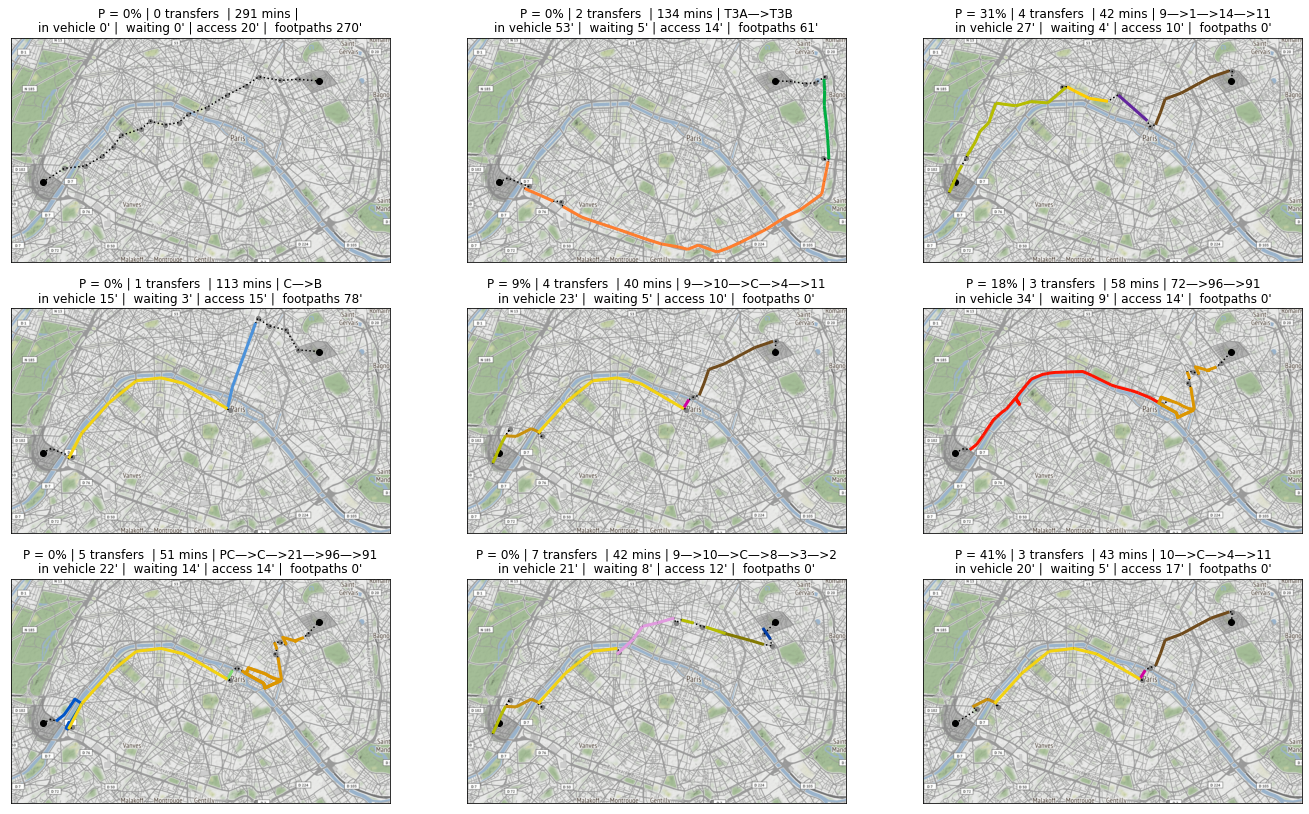

In [27]:
if manual:
    origin, destination='zone_74',  'zone_105'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'
    fig, axes = sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True

In [28]:
sm.links

,a,trip_id,link_sequence,departure_time,pickup_type,b,arrival_time,drop_off_type,time,headway,...,disaggregated_b,length,duration,cost,origin,destination,color,volume,boardings,alightings
link_0,262,098098001:DIRECT1_0,1,27600.0,0,128,27900.0,0,300.0,1200,...,node_StopPoint:14:14976,1464.267,300.0,900.0,262,128,#B20066,NaN,NaN,NaN
link_1,128,098098001:DIRECT1_0,2,27900.0,0,241,29100.0,0,1200.0,1200,...,node_StopPoint:14:410,4921.388,1200.0,1800.0,128,241,#B20066,NaN,NaN,NaN
link_2,241,098098001:DIRECT1_1,1,27540.0,0,128,28800.0,0,1260.0,1200,...,node_StopPoint:14:14977,4938.501,1260.0,1860.0,241,128,#B20066,NaN,NaN,NaN
link_3,128,098098001:DIRECT1_1,2,28800.0,0,262,29220.0,0,420.0,1200,...,node_StopPoint:14:14935,1713.097,420.0,1020.0,128,262,#B20066,NaN,NaN,NaN
link_4,135,098098002:DIRECT2_0,1,28800.0,0,262,29400.0,0,600.0,1800,...,node_StopPoint:14:14934,2443.869,600.0,1500.0,135,262,#7BBB58,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
link_4998,201,810:B_1,2,31800.0,0,175,31860.0,0,60.0,90,...,node_StopPoint:8778543:810:B,NaN,60.0,105.0,201,175,#4B92DB,10120.210580,6367.009703,3846.638520
link_4999,175,810:B_1,3,31920.0,0,211,31980.0,0,60.0,90,...,node_StopPoint:8775861:810:B,NaN,60.0,105.0,175,211,#4B92DB,7224.052157,950.480097,1258.743643
link_5000,211,810:B_1,4,32040.0,0,117,32100.0,0,60.0,90,...,node_StopPoint:8775862:810:B,NaN,60.0,105.0,211,117,#4B92DB,6138.433823,173.125309,1050.401673
link_5001,117,810:B_1,5,32160.0,0,51,32220.0,0,60.0,90,...,node_StopPoint:8775863:810:B,NaN,60.0,105.0,117,51,#4B92DB,5119.902178,31.870028,3845.255733


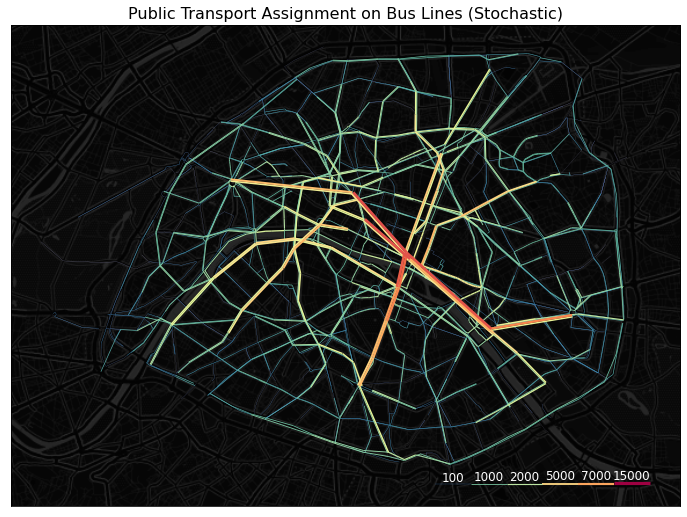

In [29]:
if manual:
    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000, 15000]
    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'

    sm.road_links['volume'] = sm.road_links[('volume', 'pt')]
    i_links = sm.links.loc[sm.links.road_length.isnull()]
    df = pd.concat([i_links, sm.road_links])
    df = df.loc[df['volume'] > 0]

    plot= bandwidth(
        df, value_column='volume', power=power, figsize=[12, 12], legend_values=lv,
        label_kwargs={'color':'white', 'fontsize':12}
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title('Public Transport Assignment on Bus Lines (Stochastic)', fontsize=16)